# Predicting Future Stock Prices Based on Current News
## or effect of news sentiment on stock prices

In [18]:
from bs4 import BeautifulSoup
import urllib2
import pandas as pd
import numpy as np

from datetime import date, timedelta, datetime
from time import sleep
import os.path

import matplotlib.pyplot as plt
%matplotlib inline

## Data
My capstone project is about effects of news on stock prices. for that I need to do my study on a well publicized stock so usually S&P 500 companies have better news coverage. Since choosing a particular stock can led to some bias and overfitting I decided to go with more than one which leads to problem of choosing those stocks. Since each stock belongs to a particular industry and usually news about a particular stock can affect the whole industry and vice versa I decided to do my study on multiple stocks in multiple industries. By using this approach we can even find out which industries are more sensitive to news.

There is a wikipedia page containig all S&P 500 companies names and in formation so we start from there.

In [19]:
if not os.path.exists('datasets/s_p_500.csv'):
    s_p_500 = pd.read_html('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies', attrs = {"class":'wikitable sortable'}, header = 0)[0]
    s_p_500.to_csv('datasets/s_p_500.csv', encoding = "utf-8")
else:
    s_p_500 = pd.read_csv('datasets/s_p_500.csv', index_col = 0)

s_p_500.columns = [x.strip().replace(' ', '_') for x in s_p_500.columns]

Now we can identify all industries

In [6]:
industries = s_p_500.GICS_Sector.unique()
industries

array(['Industrials', 'Health Care', 'Information Technology',
       'Consumer Discretionary', 'Utilities', 'Financials', 'Materials',
       'Consumer Staples', 'Real Estate', 'Energy',
       'Telecommunications Services'], dtype=object)

We are going to use 3 companies in each industry

In [7]:
companies = [s_p_500[(s_p_500.GICS_Sector == industry)].head(3) for industry in industries]
companies = pd.concat(companies, axis = 0)
companies.head()

,Ticker_symbol,Security,SEC_filings,GICS_Sector,GICS_Sub_Industry,Address_of_Headquarters,Date_first_added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
5,AYI,Acuity Brands Inc,reports,Industrials,Electrical Components & Equipment,"Atlanta, Georgia",2016-05-03,1144215
15,ALK,Alaska Air Group Inc,reports,Industrials,Airlines,"Seattle, Washington",2016-05-13,766421
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152


## News
for news source I choose Reuters. Reuters is a well known and presigeous news agency and most of all it has a great site which we grants us access to historical company news. for starter I decided get news from 2014 to present. I may need to go further later.

Reuters doesn't like `-` in symbols!!!

In [8]:
companies.Ticker_symbol = companies.Ticker_symbol.apply(lambda x: x.replace('-', ''))

This function goes through all the news starting from `start_date` to `end_date` and grabs all the news. This took me one day to get all the news!

In [9]:
def get_news_for_symbol(symbol, start_date = date(2014, 1, 1), end_date = date(2014, 1, 15)):
    def get_link(href, text, date):
        link = {}
        link['url'] = "http://www.reuters.com/"+href
        link['text'] = text
        link['symbol'] = symbol
        link['date'] = date
        link['article'] = BeautifulSoup(urllib2.urlopen(link['url']), "lxml").find_all(
            'span', {"id":"article-text"})[0].text.replace('\n', ' ')
        sleep(0.5)
        return link

    links = []
    for day in [start_date + timedelta(n) for n in range((end_date - start_date).days)]:
        url = "http://www.reuters.com/finance/stocks/companyNews?symbol = {}&date = {}".format(symbol,day.strftime('%m%d%Y'))
        news = BeautifulSoup(urllib2.urlopen(url), "lxml").find_all('div', {"id":"companyNews"})
        for i in xrange(2):
            for feature in news[i].find_all('h2'):
                a = feature.find('a')
                if a.has_attr('href'):
                    links.append(get_link(a['href'], a.text, day))
        sleep(1)
    return links

In [21]:
links = ""
if not os.path.exists('datasets/articles.csv'):
    for symbol in companies.Ticker_symbol:
        links +=  get_news_for_symbol(symbol, end_date = date.today())
    links = pd.DataFrame(links)
    links.to_csv('articles.csv', encoding = "utf-8")
else:
    links = pd.read_csv('datasets/articles.csv', index_col = 0)

links['date'] = pd.to_datetime(links['date'], format='%Y-%m-%d')

links.head()

,article,date,symbol,text,url
0,MOSCOW Jan 17 Russia's biggest home electron...,2014-01-17,MMM,Russia's M.video says consumer confidence weak...,http://www.reuters.com//article/russia-mvideo-...
1,By Lewis Krauskopf Diversified manufacture...,2014-01-30,MMM,"3M revenue growth slows, misses Wall Street ta...",http://www.reuters.com//article/us-3m-results-...
2,By Lewis KrauskopfJan 30 Diversified manufac...,2014-01-30,MMM,"UPDATE 2-3M revenue growth slows, misses Wall ...",http://www.reuters.com//article/3m-results-idU...
3,Jan 30 Diversified manufacturer 3M Co poste...,2014-01-30,MMM,Manufacturer 3M posts 11 percent rise in net i...,http://www.reuters.com//article/3m-results-idU...
4,3M Co. has invested US$15 million in one of ...,2014-03-10,MMM,SINGAPORE PRESS-3M to lift N95 mask output at ...,http://www.reuters.com//article/singapore-pres...


There are plenty of redundancy which I have yet to decide what to do with them

# Stock quotes
After geting news data we gonna need quotes data. Getting hhistorical data can become really tricky. we can use yahoo finance to get historical daily quotes and for this project I think thats enough otherwise we have to use some propriority data.

In [12]:
def get_quotes(symbol, start_date='1/1/2014', end_date=date.today().strftime('%m/%d/%Y')):
    ret = web.DataReader(symbol, data_source='yahoo', start=start_date, end=end_date)
    ret['symbol'] = symbol
    return ret

In [22]:
quotes = ""
if not os.path.exists('datasets/daily_quotes.csv'):
    quotes = [get_quotes(symbol) for symbol in companies.Ticker_symbol ]
    quotes = pd.concat(quotes, axis=0)
    quotes.to_csv('daily_quotes.csv', encoding = "utf-8")
else:
    quotes = pd.read_csv('datasets/daily_quotes.csv')

quotes['Date'] = pd.to_datetime(quotes['Date'], format='%Y-%m-%d')
    
quotes.head()

,Date,Open,High,Low,Close,Volume,Adj Close,symbol
0,2014-01-02,138.050003,139.000000,137.610001,138.130005,3052100,127.971294,MMM
1,2014-01-03,138.369995,138.880005,138.029999,138.449997,2133300,128.267753,MMM
2,2014-01-06,138.750000,139.289993,137.479996,137.630005,2712100,127.508066,MMM
3,2014-01-07,137.449997,138.199997,137.130005,137.649994,2525500,127.526585,MMM
4,2014-01-08,137.479996,137.750000,136.339996,136.630005,3122700,126.581611,MMM


## Plotting
### Quotes through time
Here is stock prices for different symbols from 2014 till last friday.

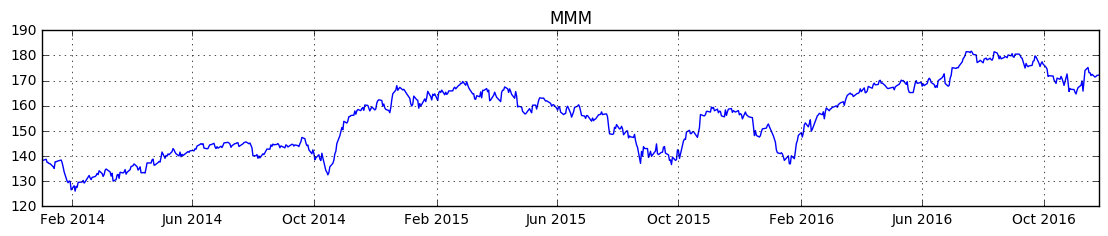

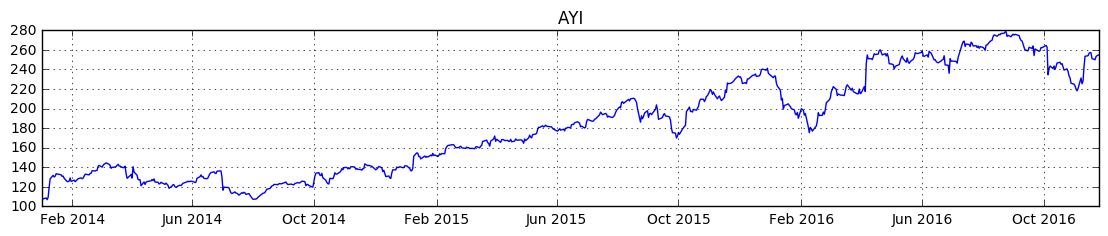

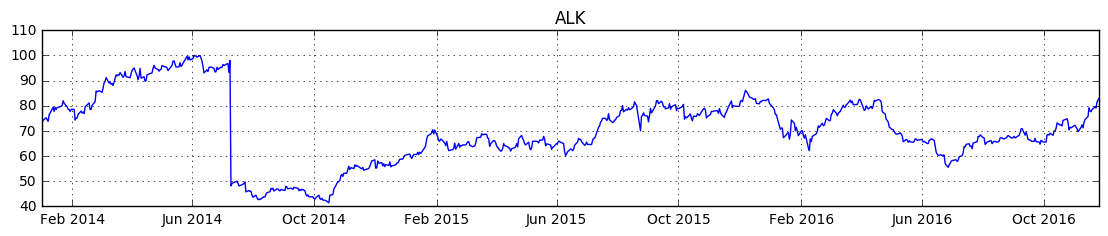

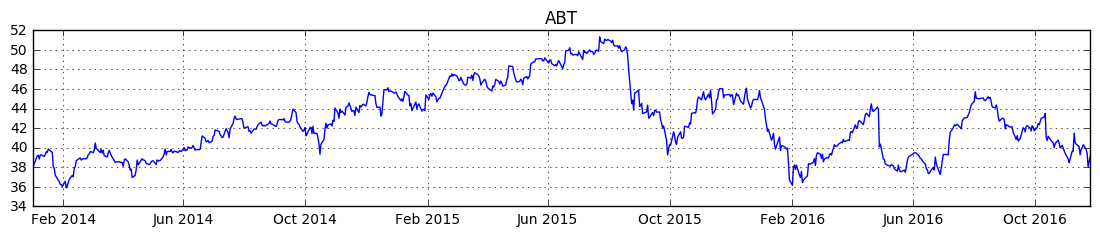

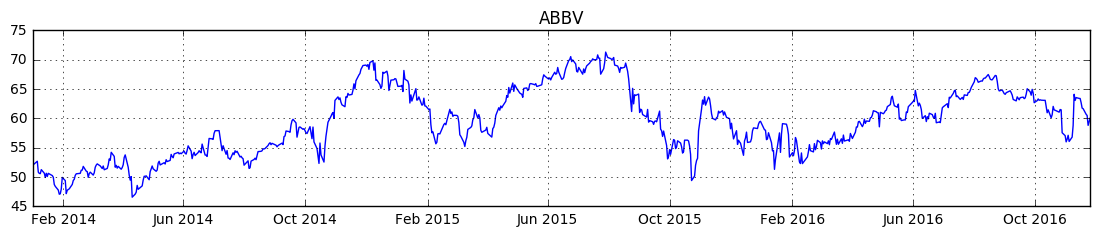

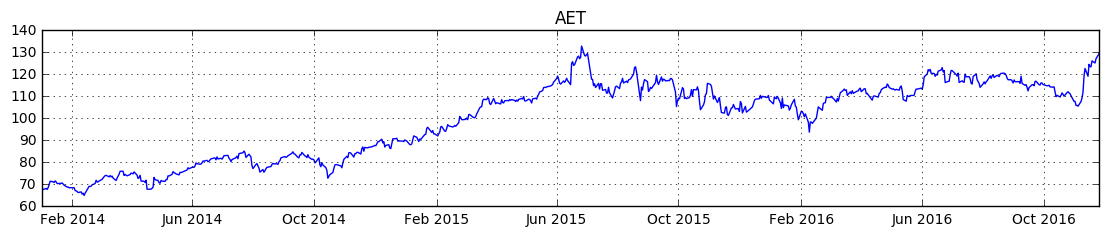

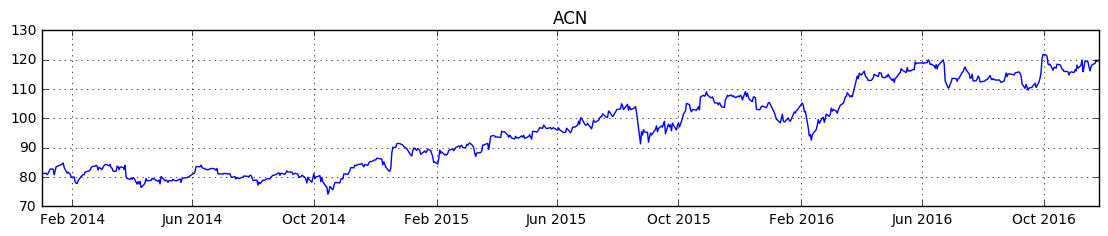

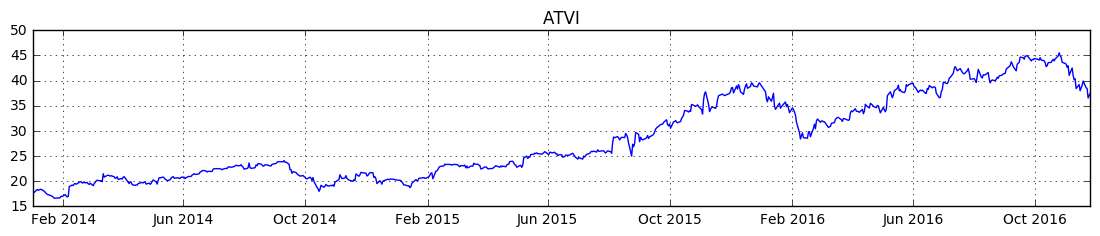

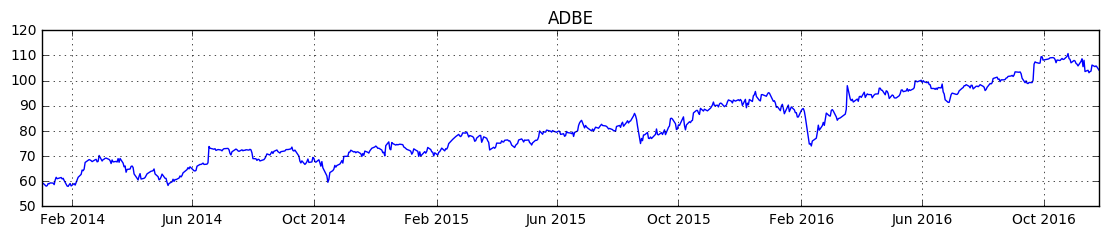

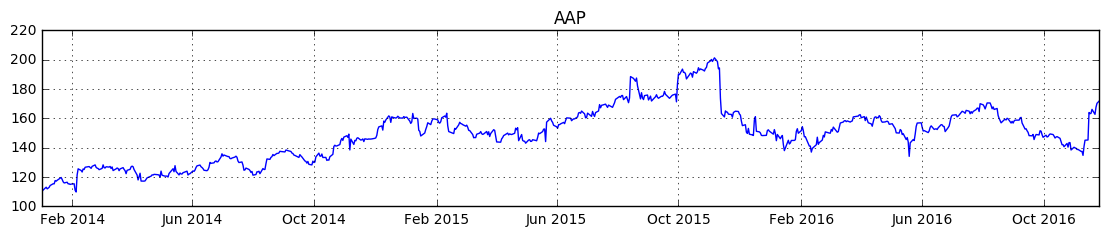

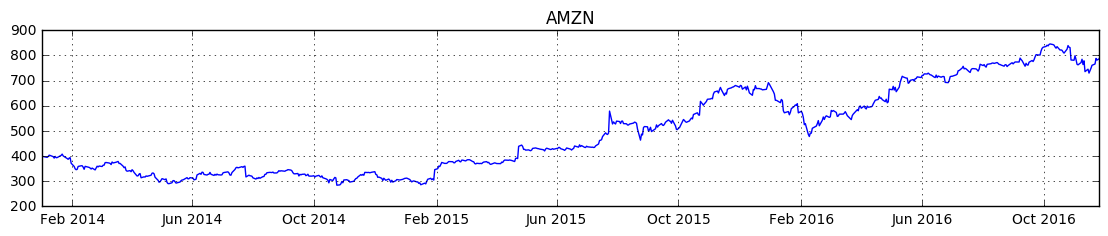

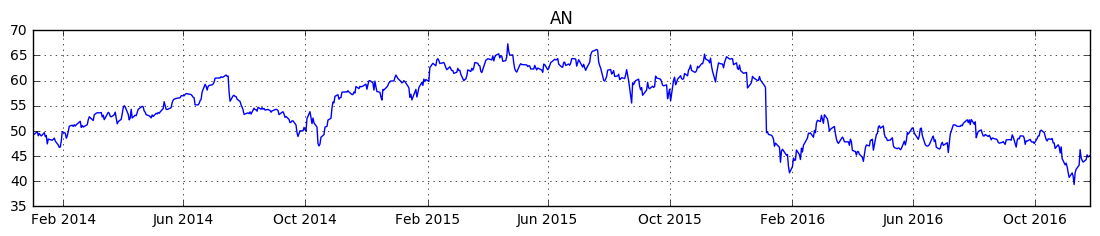

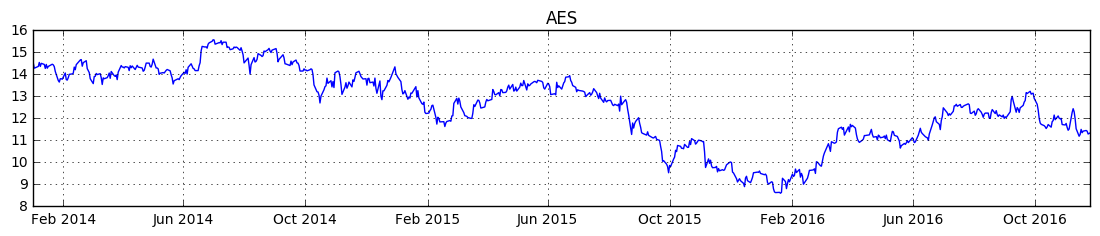

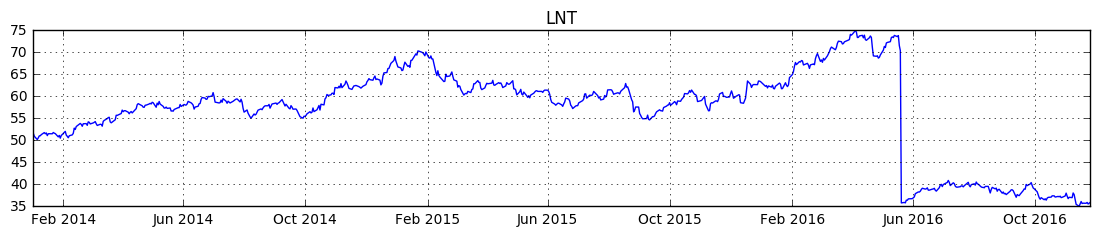

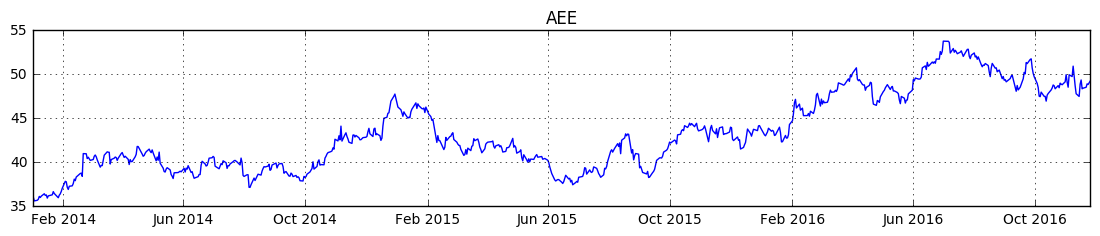

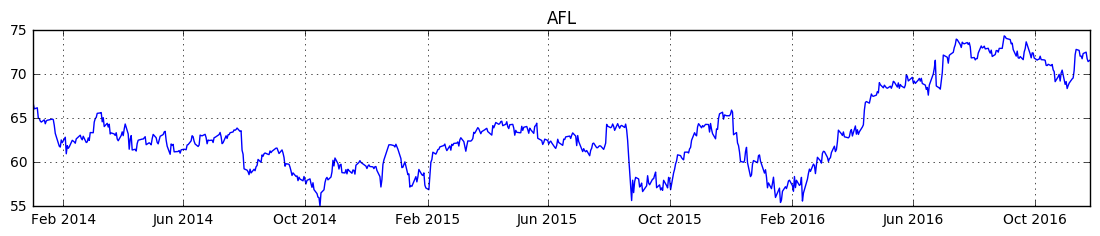

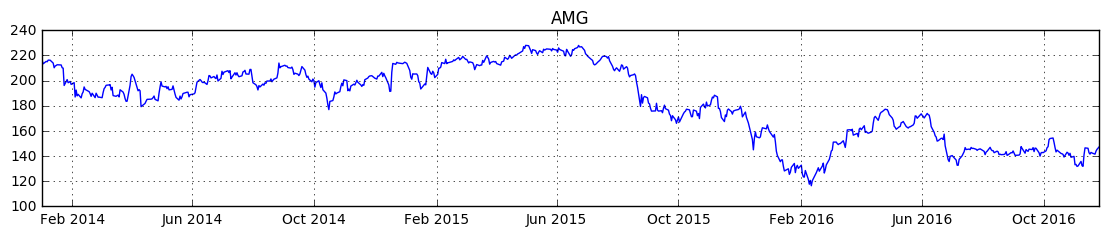

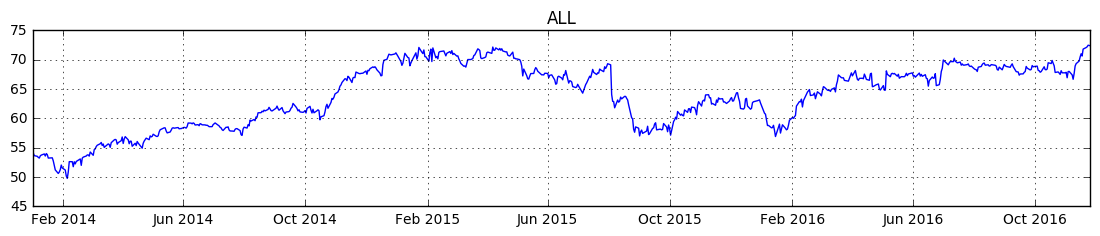

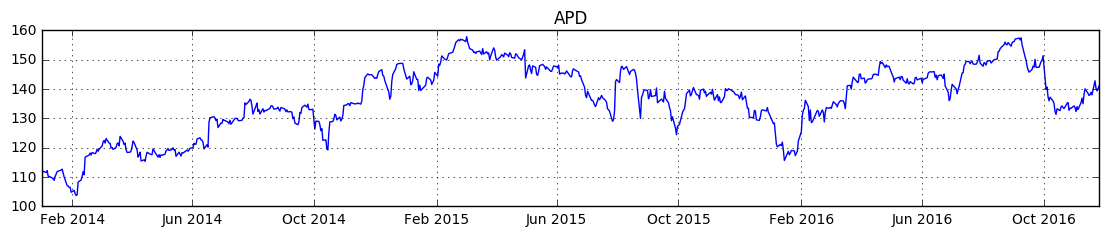

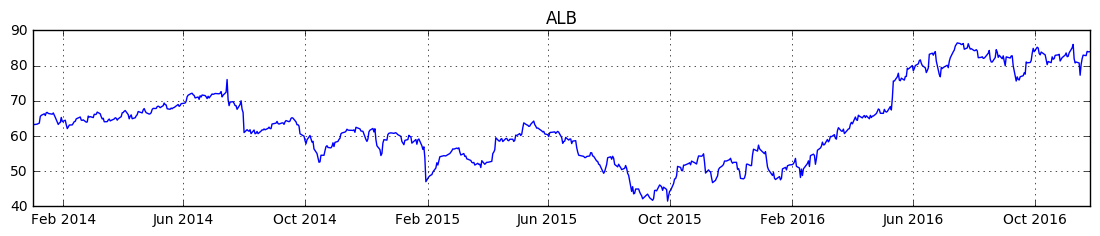

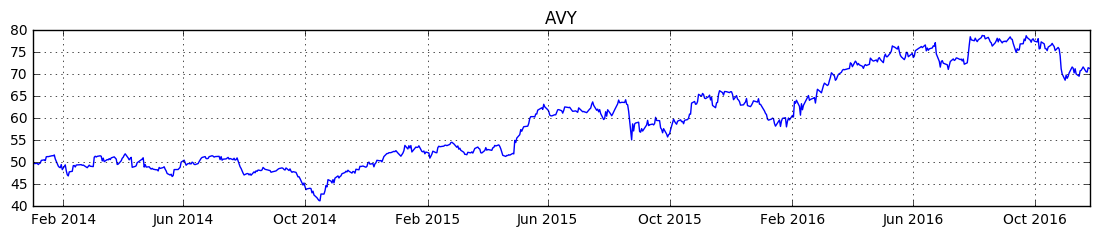

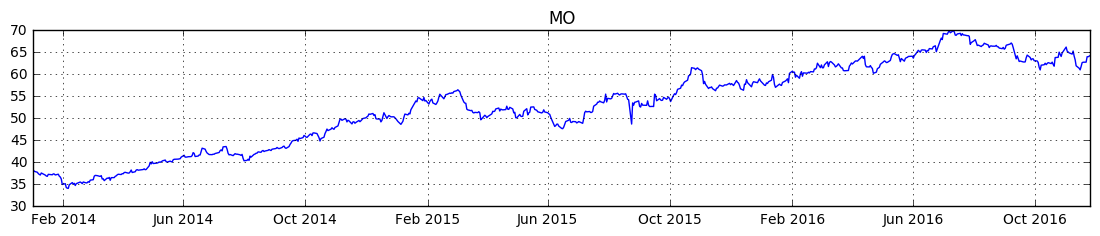

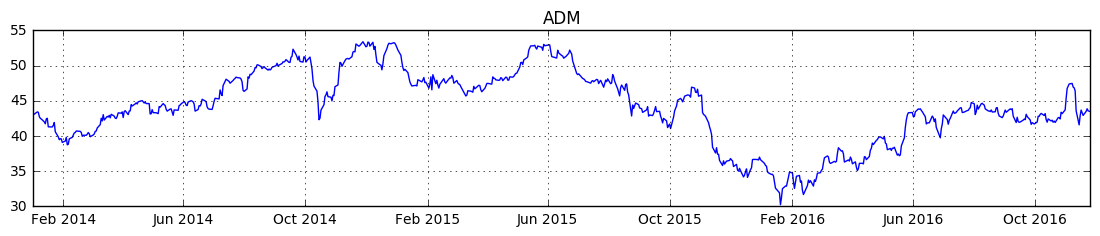

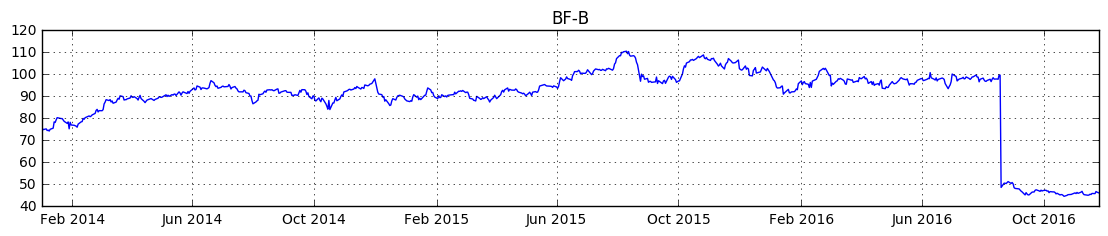

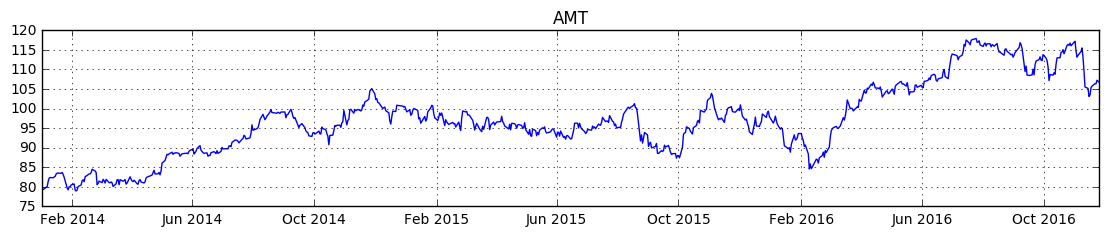

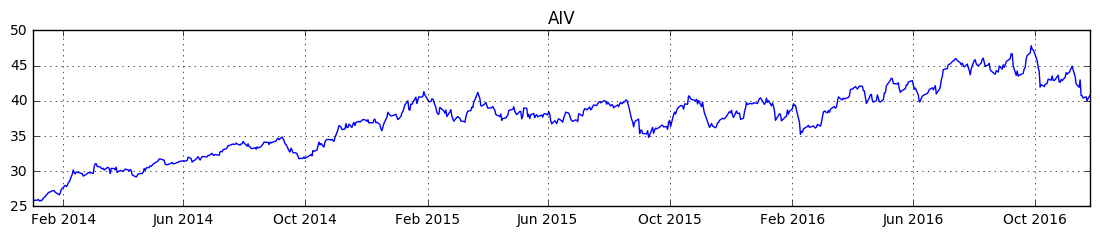

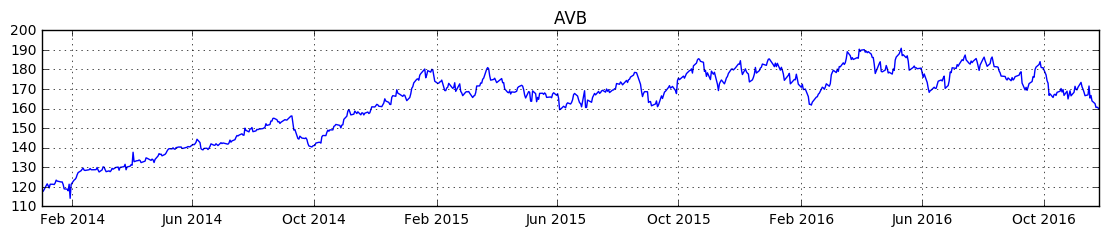

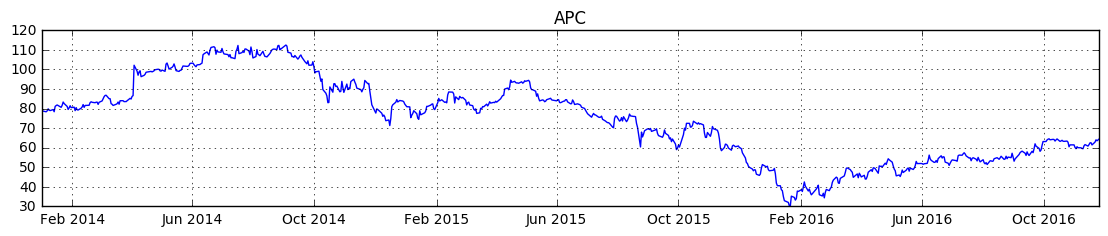

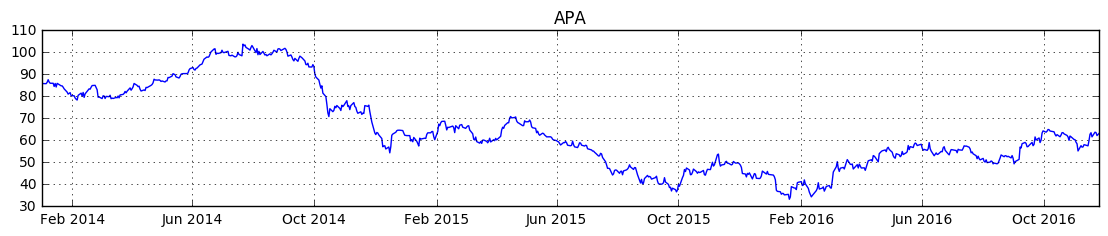

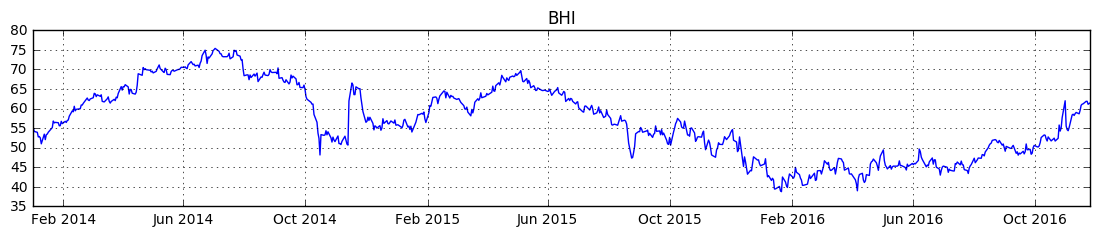

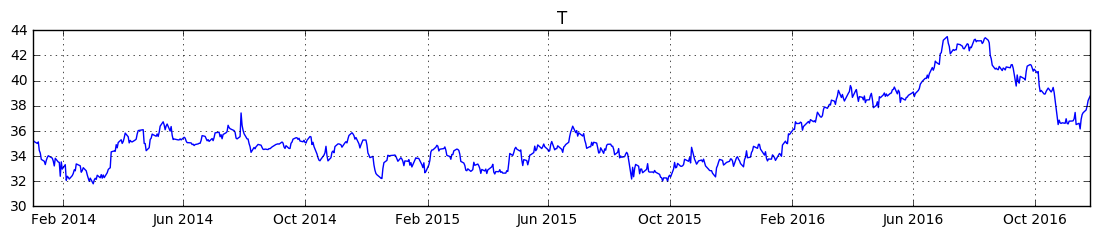

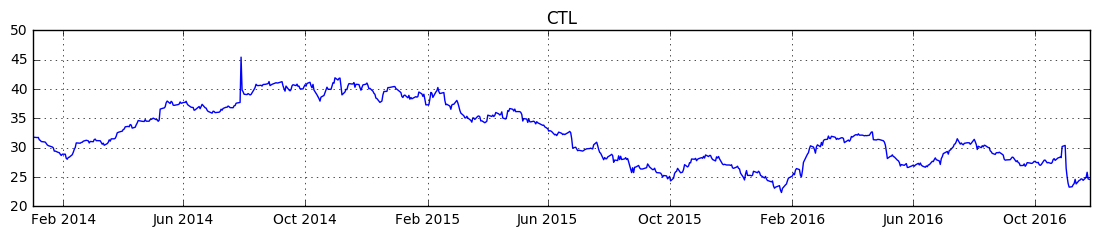

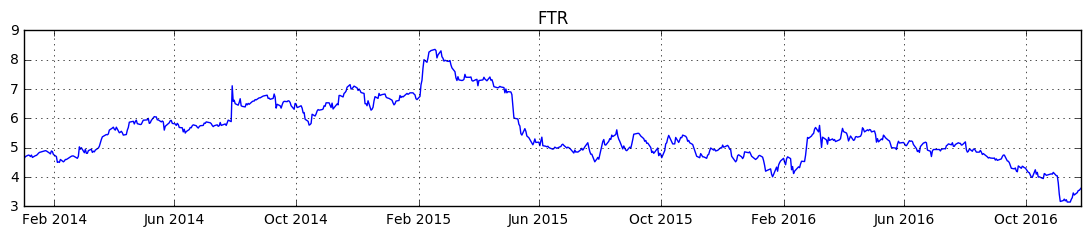

In [16]:
for symbol in quotes.symbol.unique():
    plt.figure(1, figsize=(30,5))
    plt.subplot(222)
    plt.plot('Date', 'Open', data=quotes[(quotes.symbol == symbol)])
    plt.yscale('linear')
    plt.title(symbol)
    plt.grid(True)
    plt.show()

### News through time
as we can see not all companies are news friendly!

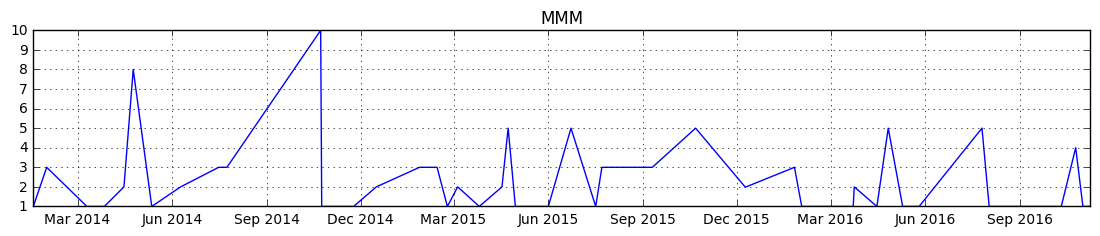

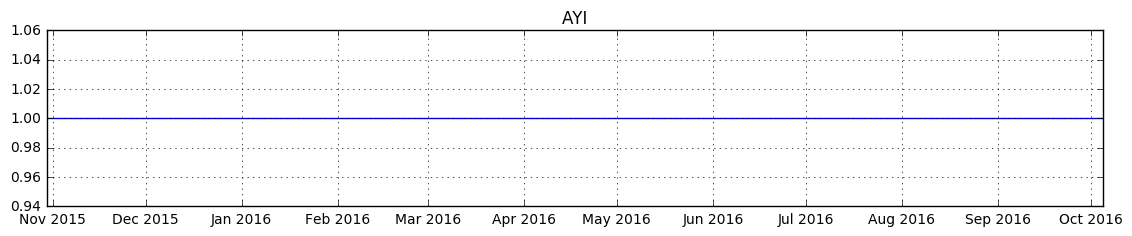

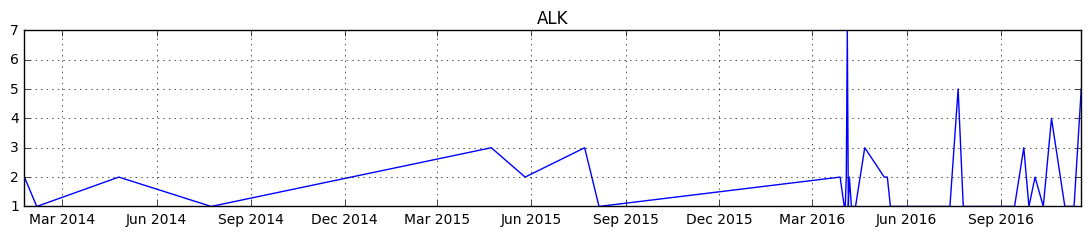

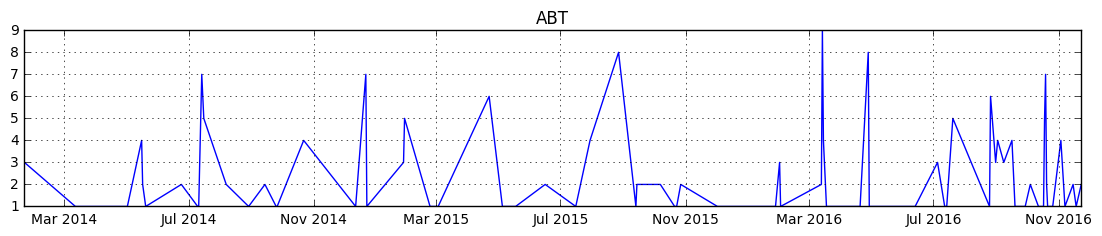

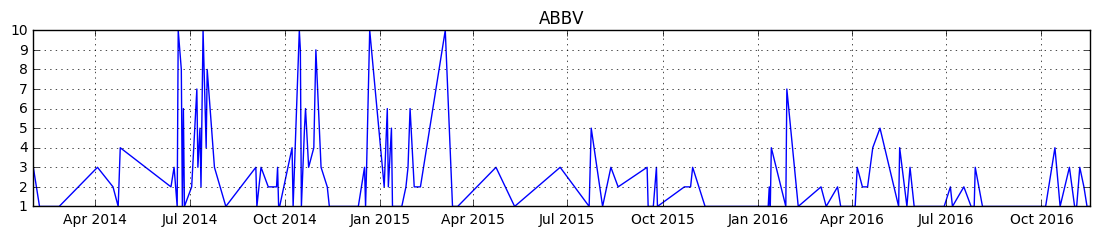

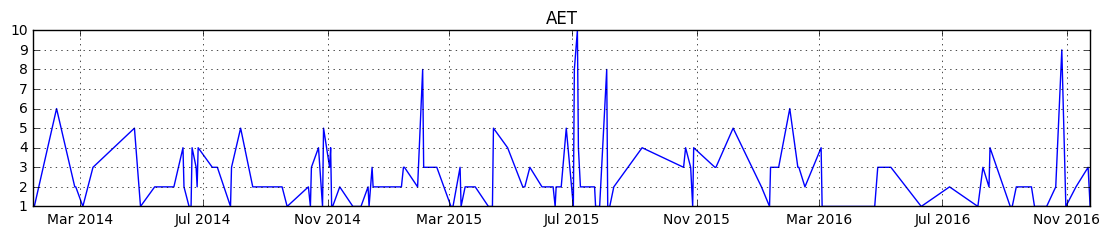

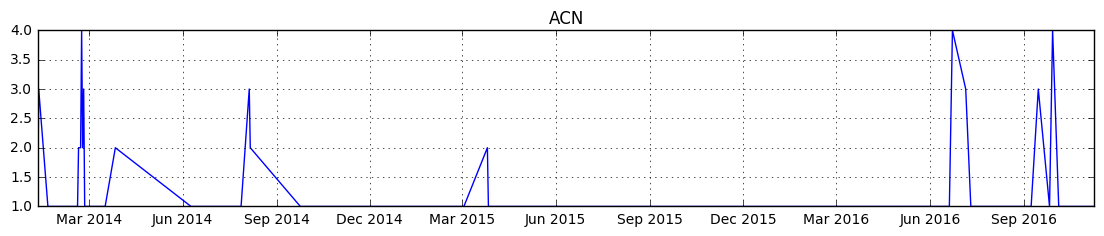

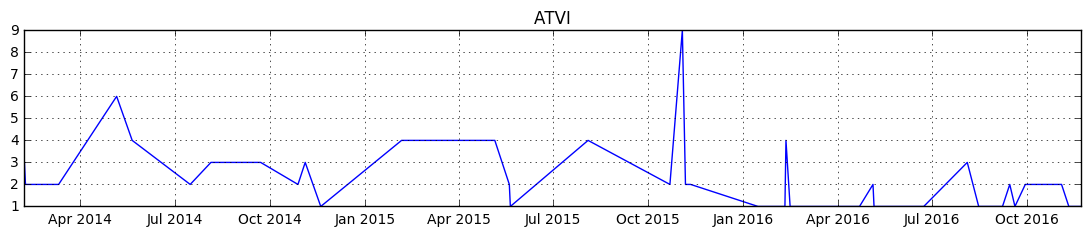

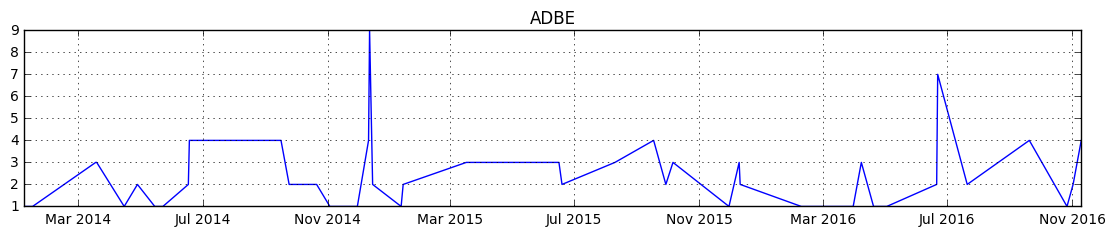

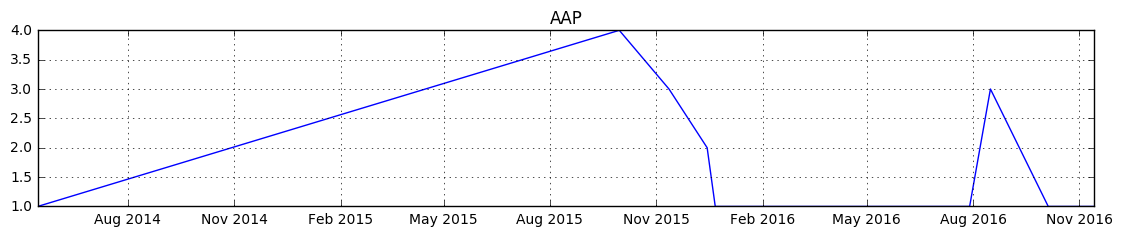

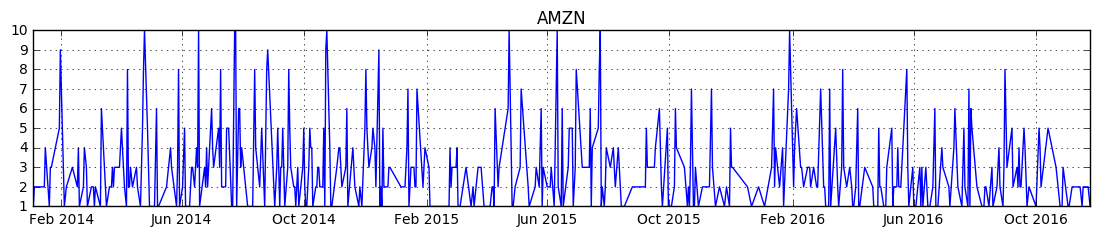

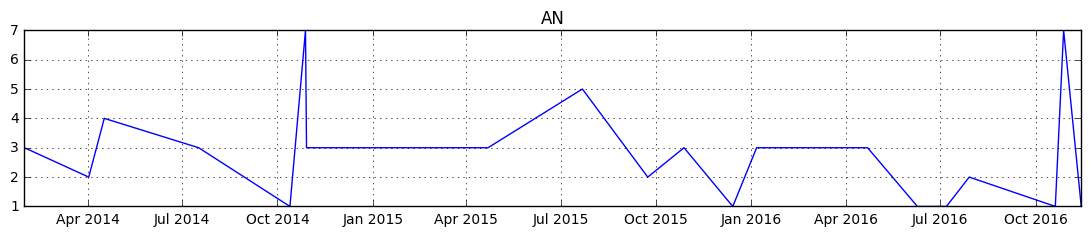

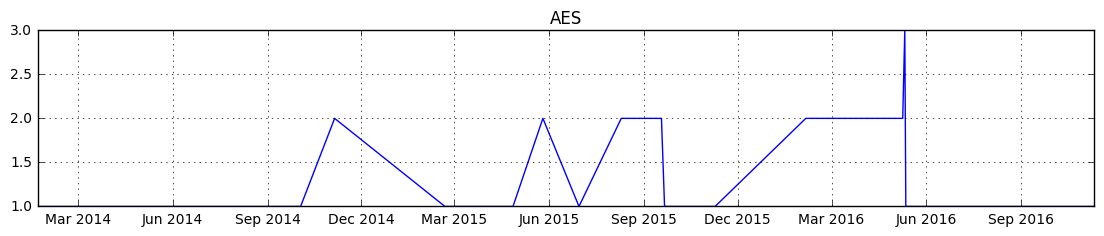

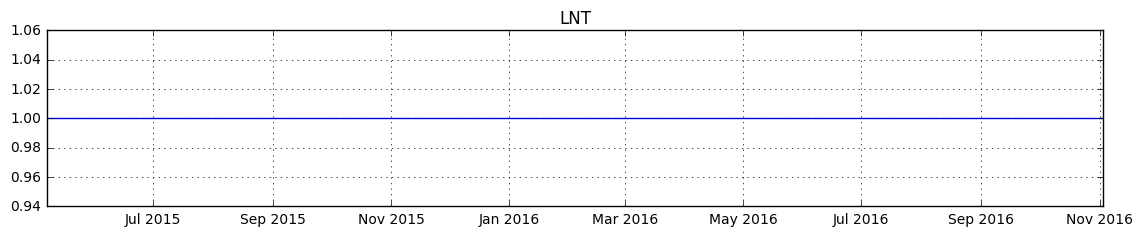

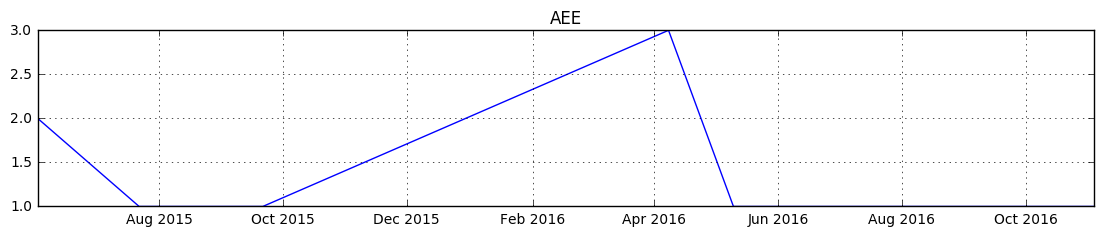

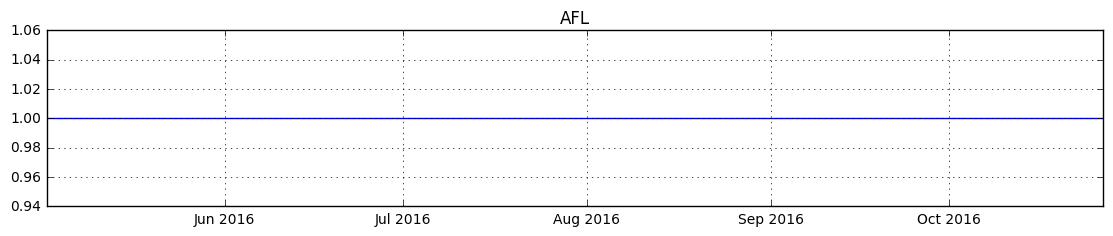

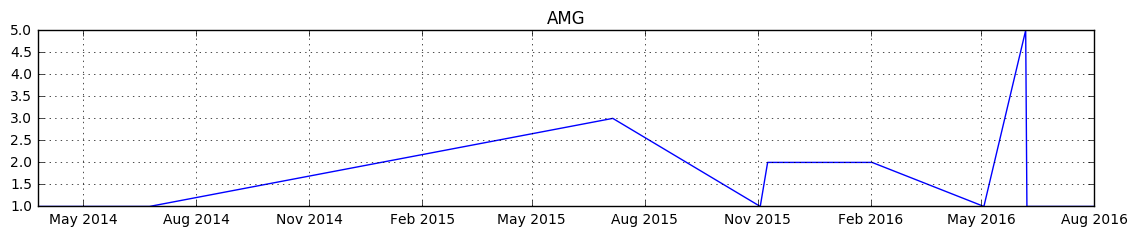

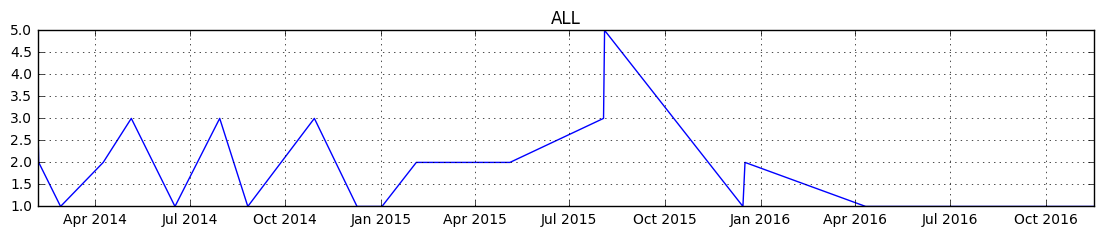

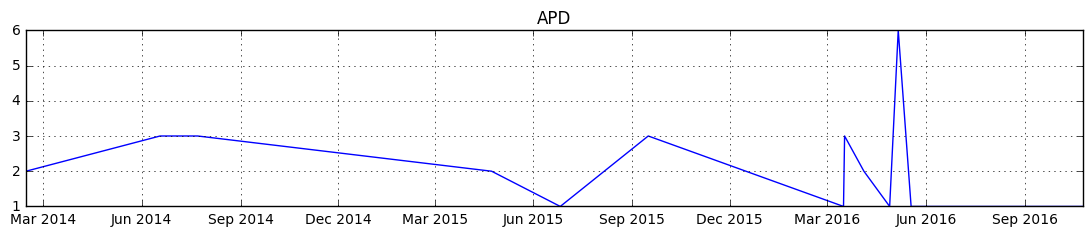

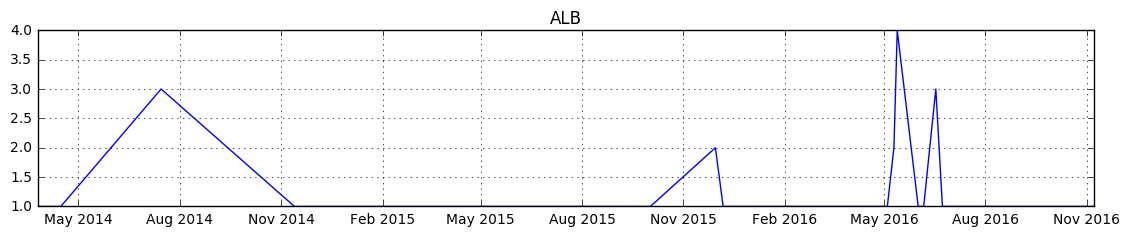

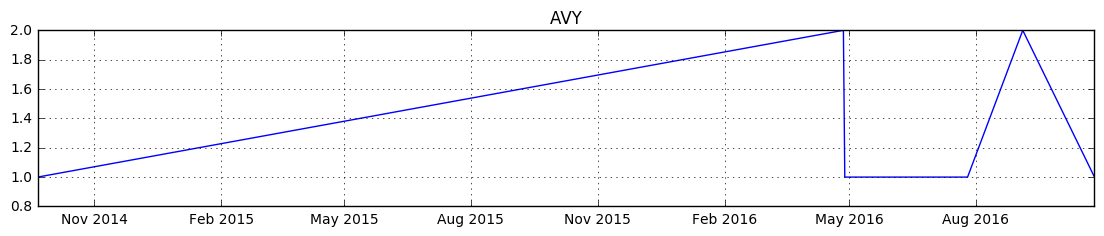

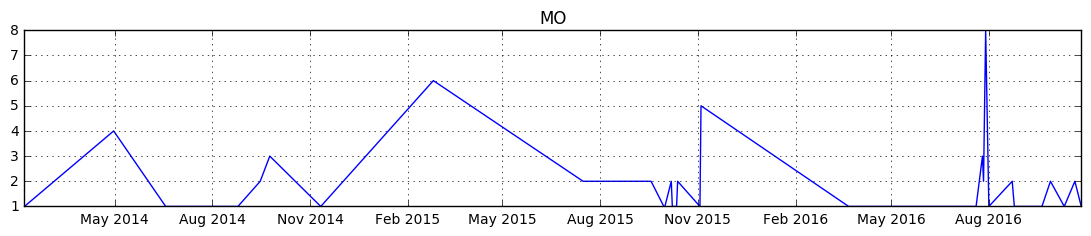

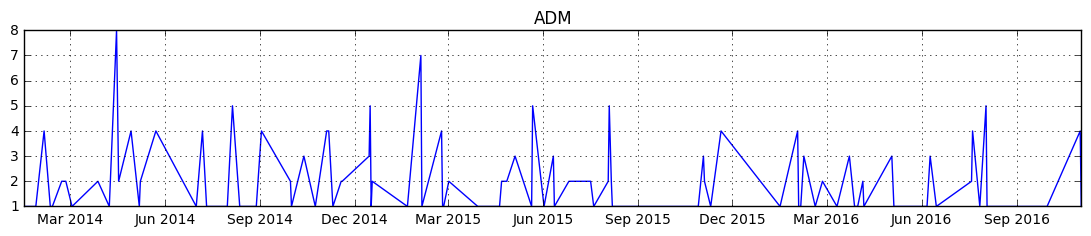

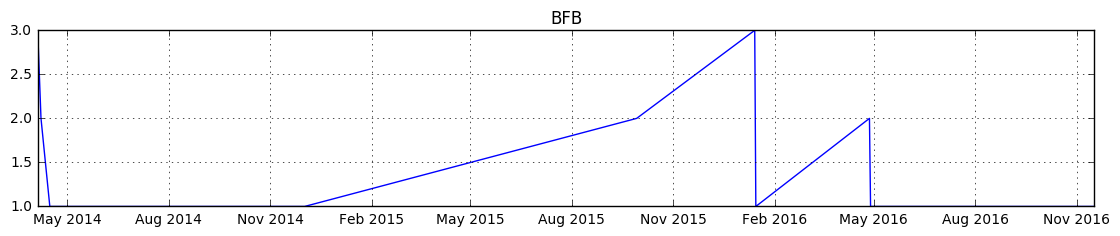

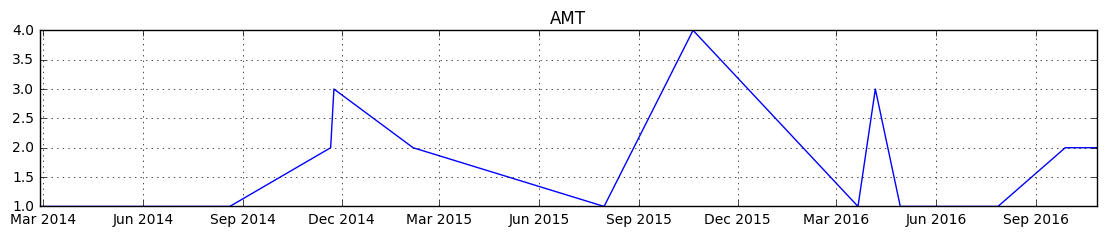

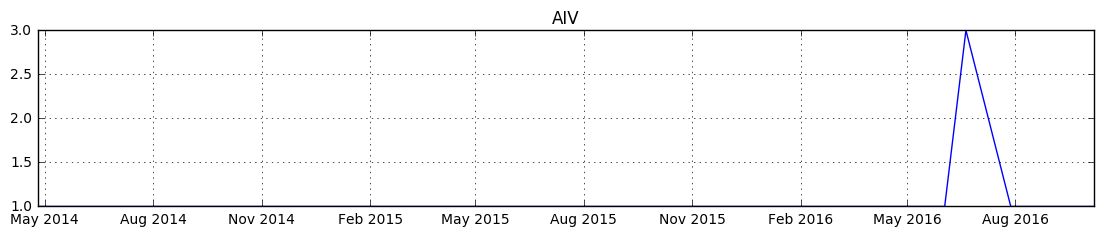

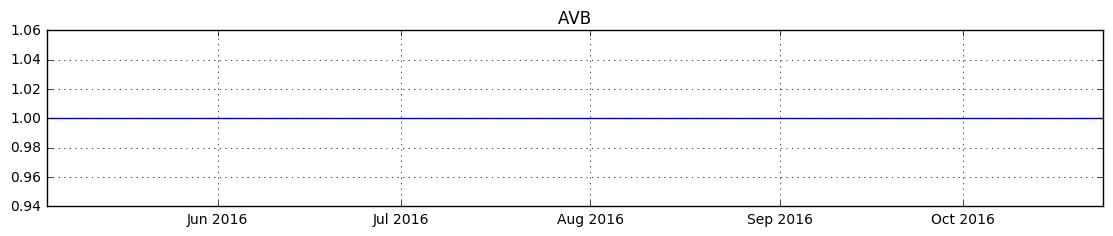

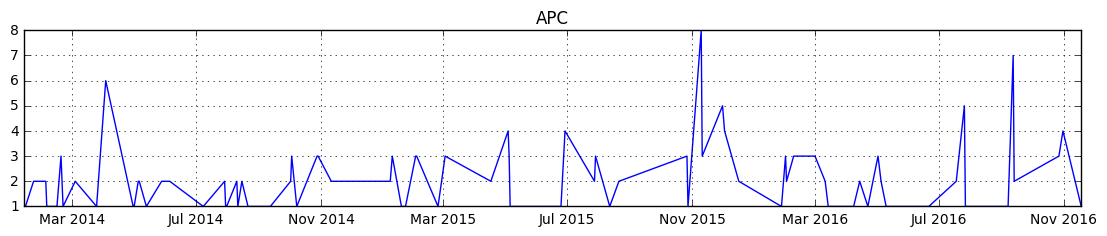

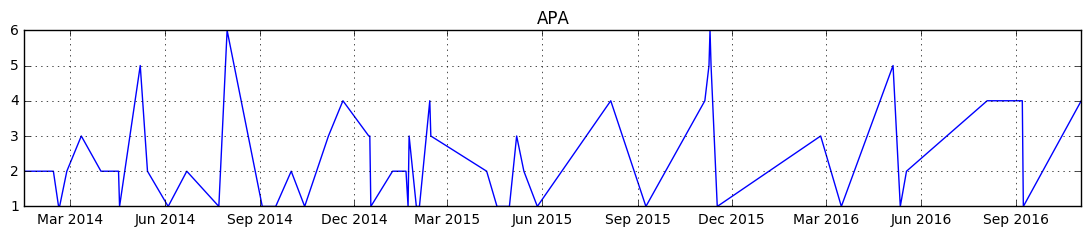

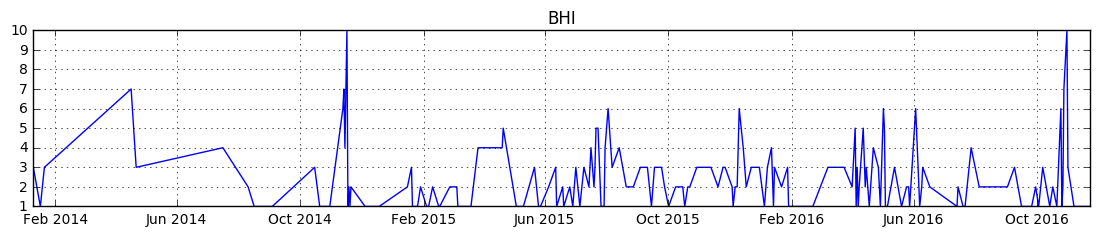

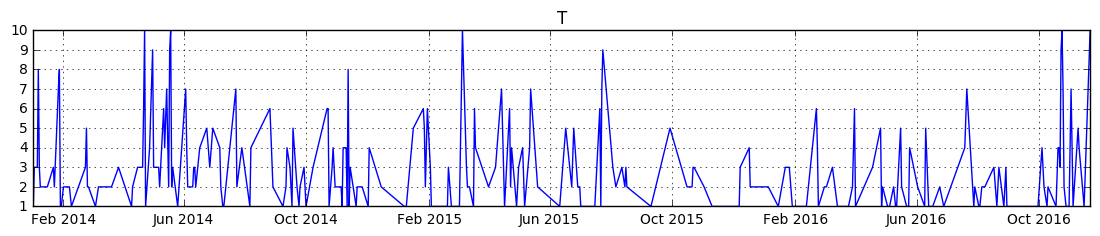

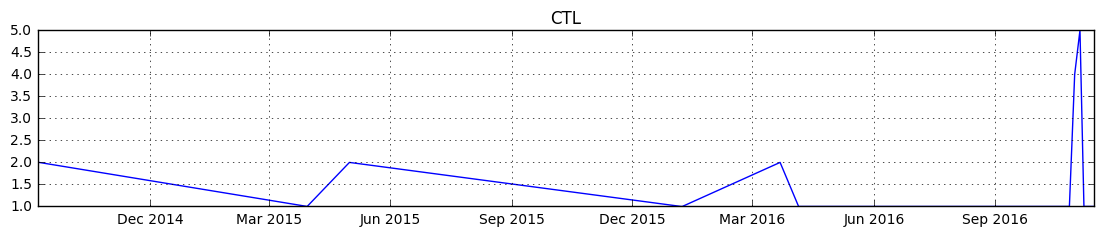

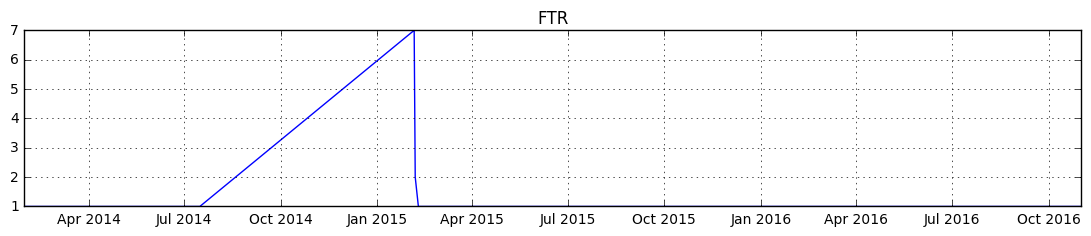

In [17]:
for symbol in links.symbol.unique():
    data=links[(links['symbol']==symbol)]
    data=pd.pivot_table(data, index='date', values='article', aggfunc=np.count_nonzero).reset_index()
    
    plt.figure(1, figsize=(30,5))
    plt.subplot(222)
    plt.plot('date', 'article', data=data)
    plt.yscale('linear')
    plt.title(symbol)
    plt.grid(True)
    plt.show()